In [65]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# comp-linguistics
import scipy
import spacy
import en_core_web_sm
import nltk

### Loading and Cleaning the data

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_review.csv")
df_meta = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_meta.csv")
df.head()

,Unnamed: 0,asin,title,overall,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN
1,1,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN
2,2,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN
3,3,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 15, 2018",A2FMMCFQ8702DN,{'Style:': ' Business'},Wickenball,Love it.,Five Stars,1526342400,NaN
4,4,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 12, 2018",A1I8WBJSZIPJE0,{'Style:': ' Business'},B. Stearn,I've had various versions of this keyboard for...,Five Stars,1526083200,NaN


In [8]:
tbl = df.groupby('asin').agg({'overall':'count'})
tbl = tbl.sort_values(by = ['overall'], ascending = False)
tbl['asin'] = tbl.index
tbl = tbl.rename_axis("ID")
tbl

,overall,asin
ID,,
B000A6PPOK,2567,B000A6PPOK
B00I0S6SK0,1805,B00I0S6SK0
B00KF9IVKC,1092,B00KF9IVKC
B00D9UTZWW,523,B00D9UTZWW
B00NG8EJOG,521,B00NG8EJOG
B00E4TOWR0,418,B00E4TOWR0
B00O1B59AU,387,B00O1B59AU
B00LSGKEC4,378,B00LSGKEC4
B0194MC7JG,343,B0194MC7JG


In [18]:
df = df[df['reviewText'].notnull()]
df_agg = df.groupby(['asin', 'title'], as_index=False)[['reviewText']].agg(sum)
df_agg

,asin,title,reviewText
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach..."
1,B004HJDUW0,Monoprice 32ft 10M USB 2.0 A Male to A Female ...,I have a LifeCam VX-5000 HD webcam on the end ...
2,B00D9UTZWW,"iBenzer MacBook Air 11 Inch Case, Soft Touch H...","Don't love the keyboard screen, but the case i..."
3,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...
4,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....
5,B00KF9IVKC,iPazzPort 3-color Backlit Wireless Mini Keyboa...,For $11.99 you can't go wrong. The keyboard ha...
6,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive..."
7,B00NG8EJOG,"Foldable Bluetooth Keyboard, Jelly Comb B003B ...",Outstanding little bluetooth keyboard. I'm usi...
8,B00O1B59AU,"ZAGG Slim Book Ultrathin Case, Hinged with Det...",Zagg has really gone downhill in quality. I'v...
9,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...


In [19]:
df_agg['tokenized_words'] = df_agg['reviewText'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_agg['normalized_words'] = df_agg['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [33]:
df_agg

,asin,title,reviewText,tokenized_words,normalized_words
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach...","[As, a, software, developer, I, am, literally,...","[software, developer, literally, attached, key..."
1,B004HJDUW0,Monoprice 32ft 10M USB 2.0 A Male to A Female ...,I have a LifeCam VX-5000 HD webcam on the end ...,"[I, have, a, LifeCam, VX-5000, HD, webcam, on,...","[lifecam, vx-5000, hd, webcam, end, dropped, f..."
2,B00D9UTZWW,"iBenzer MacBook Air 11 Inch Case, Soft Touch H...","Don't love the keyboard screen, but the case i...","[Do, n't, love, the, keyboard, screen, but, th...","[love, keyboard, screen, case, great, use, key..."
3,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...,"[Love, it, The, keys, are, placed, where, I, l...","[love, keys, placed, like, bethis, keyboard, f..."
4,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....,"[This, is, just, what, I, needed, and, it, wor...","[needed, works, great, lights, great, night, l..."
5,B00KF9IVKC,iPazzPort 3-color Backlit Wireless Mini Keyboa...,For $11.99 you can't go wrong. The keyboard ha...,"[For, $, 11.99, you, ca, n't, go, wrong, The, ...","[$, wrong, keyboard, nice, rubber, texture, fe..."
6,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive...","[This, would, have, been, five, stars, but, I,...","[stars, received, bad, keyboard, initially, fu..."
7,B00NG8EJOG,"Foldable Bluetooth Keyboard, Jelly Comb B003B ...",Outstanding little bluetooth keyboard. I'm usi...,"[Outstanding, little, bluetooth, keyboard, I, ...","[outstanding, little, bluetooth, keyboard, m, ..."
8,B00O1B59AU,"ZAGG Slim Book Ultrathin Case, Hinged with Det...",Zagg has really gone downhill in quality. I'v...,"[Zagg, has, really, gone, downhill, in, qualit...","[zagg, gone, downhill, quality, ve, older, zag..."
9,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...,"[I, did, n't, think, it, would, be, possible, ...","[think, possible, set, ve, day, desktop, compu..."


### HW5:Topic Extraction

In [25]:
dictionary = gensim.corpora.Dictionary(df_agg['normalized_words'])

In [26]:
corpus = [dictionary.doc2bow(text) for text in df_agg['normalized_words']]

In [27]:
gensim.corpora.MmCorpus.serialize('amazon.mm', corpus)
senmm = gensim.corpora.MmCorpus('amazon.mm')

In [28]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [29]:
sen1Bow = dictionary.doc2bow(df_agg['normalized_words'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(df_agg['asin'][0]))
print("are: {}".format(sen1lda))

The topics of the text: B000A6PPOK
are: [(1, 0.40738758), (3, 0.26600927), (4, 0.026094388), (6, 0.25996426), (8, 0.015900228), (9, 0.01689523)]


In [38]:
ldaDF = pd.DataFrame({
        'name' : df_agg['asin'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in df_agg['normalized_words']]
    })

In [39]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,B000A6PPOK,"[(1, 0.3371164), (3, 0.30347288), (4, 0.024923...",0.000000,0.337116,0.000000,0.303473,0.024924,0.000000,0.297864,0.000000,0.012290,0.014894
1,B004HJDUW0,"[(5, 0.9997333)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.999733,0.000000,0.000000,0.000000,0.000000
2,B00D9UTZWW,"[(8, 0.9997709)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999771,0.000000
3,B00E4TOWR0,"[(0, 0.020191958), (1, 0.71615493), (4, 0.1758...",0.020192,0.716155,0.000000,0.000000,0.175853,0.000000,0.070172,0.000000,0.015037,0.000000
4,B00I0S6SK0,"[(1, 0.9861524), (4, 0.010192773)]",0.000000,0.986152,0.000000,0.000000,0.010193,0.000000,0.000000,0.000000,0.000000,0.000000
5,B00KF9IVKC,"[(1, 0.9974674)]",0.000000,0.997467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,B00LSGKEC4,"[(1, 0.5155969), (4, 0.02236618), (6, 0.461832...",0.000000,0.515597,0.000000,0.000000,0.022366,0.000000,0.461832,0.000000,0.000000,0.000000
7,B00NG8EJOG,"[(1, 0.8100613), (2, 0.010224633), (4, 0.03127...",0.000000,0.810061,0.010225,0.000000,0.031273,0.000000,0.076383,0.017306,0.045705,0.000000
8,B00O1B59AU,"[(8, 0.9999013)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999901,0.000000
9,B0194MC7JG,"[(1, 0.2457144), (3, 0.7389244)]",0.000000,0.245714,0.000000,0.738924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.337116,0.000000,0.303473,0.024924,0.000000,0.297864,0.000000,0.012290,0.014894
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.999733,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999771,0.000000
3,0.020192,0.716155,0.000000,0.000000,0.175853,0.000000,0.070172,0.000000,0.015037,0.000000
4,0.000000,0.986152,0.000000,0.000000,0.010193,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.997467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.515597,0.000000,0.000000,0.022366,0.000000,0.461832,0.000000,0.000000,0.000000
7,0.000000,0.810061,0.010225,0.000000,0.031273,0.000000,0.076383,0.017306,0.045705,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999901,0.000000
9,0.000000,0.245714,0.000000,0.738924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


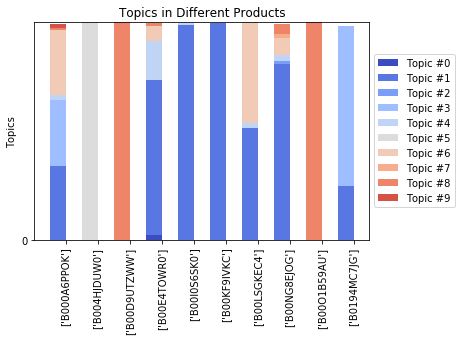

In [47]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Different Products')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

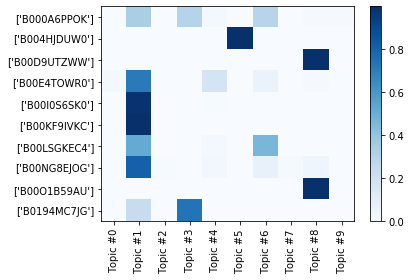

In [48]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [52]:
senlda.show_topic(1)

[('keyboard', 0.04506849),
 ('keys', 0.021948308),
 ('like', 0.0149176475),
 ('great', 0.012087135),
 ('use', 0.011953267),
 ('good', 0.008103471),
 ('works', 0.007452625),
 ('work', 0.007183087),
 ('key', 0.006694678),
 ('love', 0.0059584193)]

In [53]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,keyboard,keyboard,keyboard,keyboard,keyboard,keyboard,keyboard,keyboard,keyboard,keyboard
1,keys,keys,keys,keys,keys,keys,keys,keys,keys,keys
2,great,like,use,use,use,use,like,like,great,use
3,use,great,key,like,like,key,key,use,use,key
4,key,use,great,key,key,like,great,great,case,great
5,like,good,good,great,great,works,use,works,like,like
6,works,works,work,work,good,great,time,key,ipad,works
7,work,work,works,type,work,good,works,work,good,keyboards
8,keyboards,key,product,love,love,keyboards,love,good,key,type
9,love,love,typing,mouse,keyboards,work,typing,love,work,work


We can see a great number of overlapping between different reviews among different topics, which quite make sense since different reviewers might have similar comments on the similar keyboards product.

### HW1: Counting Words

In [59]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

#### KL Divergence

In [63]:
corpora = []
for index, row in df_agg.iterrows():
    corpora.append(row['tokenized_words'])
fileids = list(df_agg['asin']) 

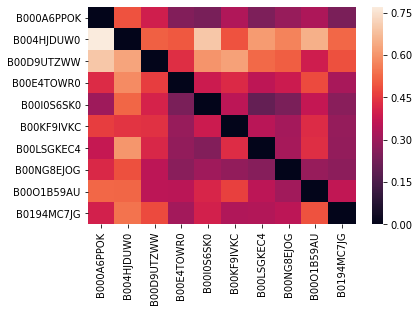

In [66]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

#### $\chi^2$ Divergence

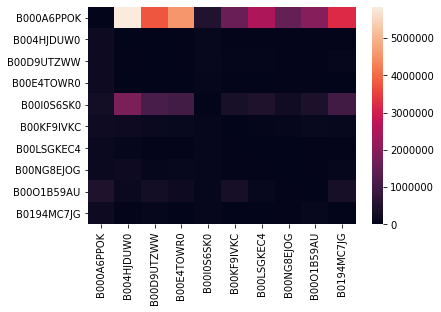

In [67]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

#### KS Distance

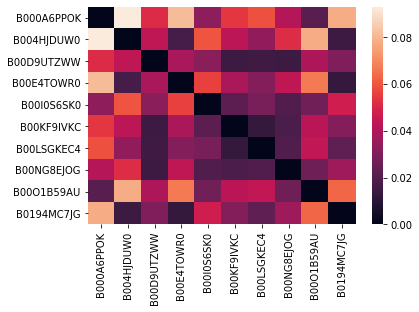

In [68]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

#### Wasserstein Distance

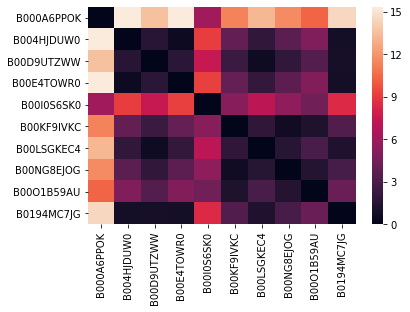

In [69]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

#### Multidimensional Scaling

C:\Users\qmun\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


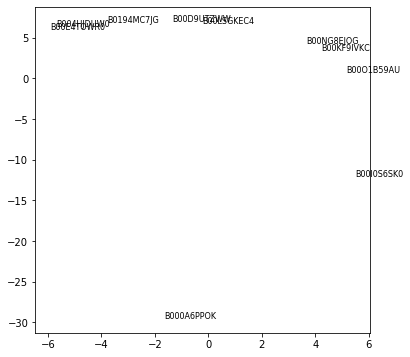

In [71]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]), size=8)

#### HW7: Text Generation

See Colab: Project_Text_Generation.ipynb